# YOLO11n-SEG Inference

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
!nvcc --version

import os
import torch
from IPython import get_ipython


BASE_PATH = os.path.dirname(os.getcwd())
VISIBLE_GPUS = [3,4,6]

os.environ["CUDA_VISIBLE_DEVICES"] = str(VISIBLE_GPUS).replace("]", "").replace("[","").replace(" ", "")
os.environ["NVIDIA_VISIBLE_DEVICES"] = str(VISIBLE_GPUS).replace("]", "").replace("[","").replace(" ", "")
print("CUDA GPUS NUMBER: ", torch.cuda.device_count())

In [ ]:
from ultralytics import YOLO

model = YOLO('/model_weights/YOLO11n-seg/best.pt')
PROJECT_PATH = '/path/to/your/project'

YAML_RELATIVE_PATH = "/dataset/data.yaml"
DATA_YAML = os.path.join(BASE_PATH, YAML_RELATIVE_PATH) 

In [ ]:
import numpy as np
import json
import os

class NPEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return super().default(obj)

In [ ]:
metrics_test = model.val(save_json=True, project=PROJECT_PATH, name="test", split="test")
metrics_val = model.val(save_json=True, project=PROJECT_PATH, name="val", split="val")


summary_json = {
    "metrics": metrics_val.results_dict,
    "speed": metrics_val.speed,
}
summary_json["metrics"].update({"map50": metrics_val.seg.map50})
summary_json["metrics"].update({"map75": metrics_val.seg.map75})
summary_json["metrics"].update({"f1": metrics_val.seg.f1})

with open(os.path.join(PROJECT_PATH, "val/val_summary.json"), "w") as of:
    json.dump(summary_json, of, cls=NPEncoder)

summary_json = {
    "metrics": metrics_test.results_dict,
    "speed": metrics_test.speed,
}
summary_json["metrics"].update({"map50": metrics_test.seg.map50})
summary_json["metrics"].update({"map75": metrics_test.seg.map75})
summary_json["metrics"].update({"f1": metrics_test.seg.f1})

with open(os.path.join(PROJECT_PATH, "test/test_summary.json"), "w") as of:
    json.dump(summary_json, of, cls=NPEncoder)

In [8]:
print(metrics_test.seg.map50)
print(metrics_test.seg.map75)
print(metrics_val.seg.map50)
print(metrics_val.seg.map75)

0.5002588215280105
0.40950478490625947
0.4918070646092144
0.406441173763082


In [ ]:
import glob
import os

def list_image_paths(image_dir, extensions=('png', 'jpg', 'jpeg', 'tif', 'tiff', 'bmp')):
    files = []
    for ext in extensions:
        files.extend(glob.glob(os.path.join(image_dir, f'*.{ext}')))
    return sorted(files)

image_path = '/dataset/train/images'
image_paths = list_image_paths(image_path)
print(len(image_paths))

2472



0: 608x800 5 pap_anormals, 1.4ms
1: 608x800 4 pap_anormals, 1 pap_sanguinea, 1.4ms
2: 608x800 4 pap_anormals, 5 pap_fora_de_focos, 3 pap_sanguineas, 1.4ms
3: 608x800 3 pap_anormals, 2 pap_fora_de_focos, 1.4ms
4: 608x800 6 pap_anormals, 1.4ms
Speed: 2.4ms preprocess, 1.4ms inference, 0.7ms postprocess per image at shape (1, 3, 608, 800)
GT path: /home/jovyan/arquivos/Citologia/Datasets/Unificado/v1/yolo_format/test/labels/2019_07_10__14_48__0045_b0s0c0x100907-1600y88659-1200m12288.txt


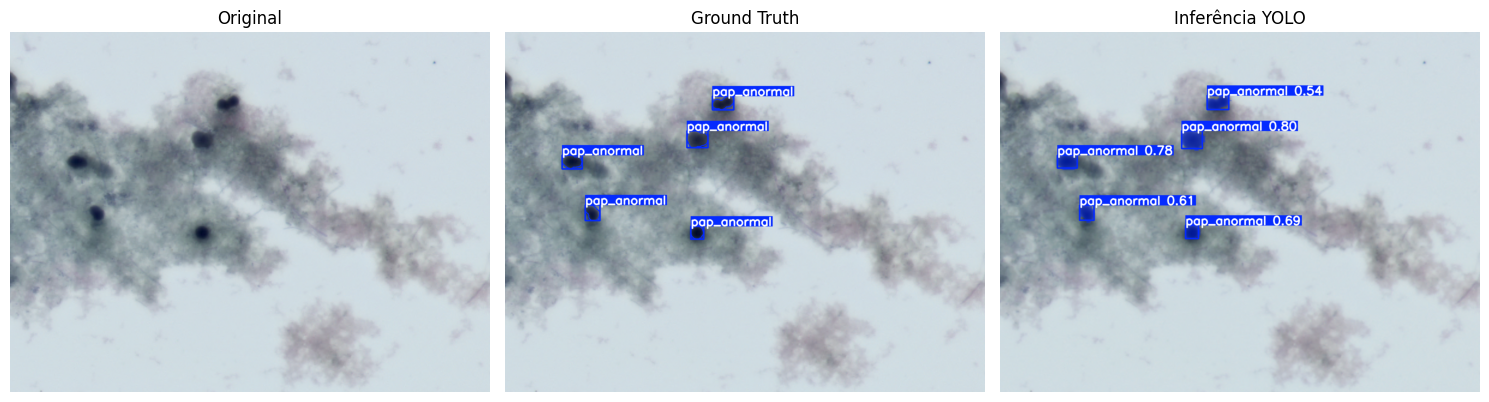

GT path: /home/jovyan/arquivos/Citologia/Datasets/Unificado/v1/yolo_format/test/labels/2019_07_10__14_48__0045_b0s0c0x100912-1600y86502-1200m11990.txt


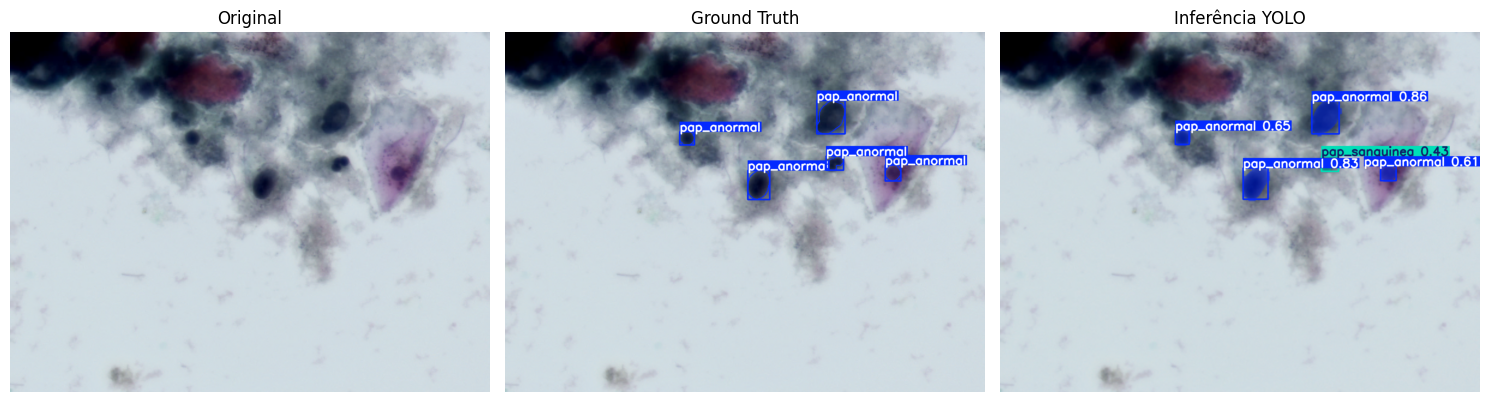

GT path: /home/jovyan/arquivos/Citologia/Datasets/Unificado/v1/yolo_format/test/labels/2019_07_10__14_48__0045_b0s0c0x100951-1600y61670-1200m8563.txt


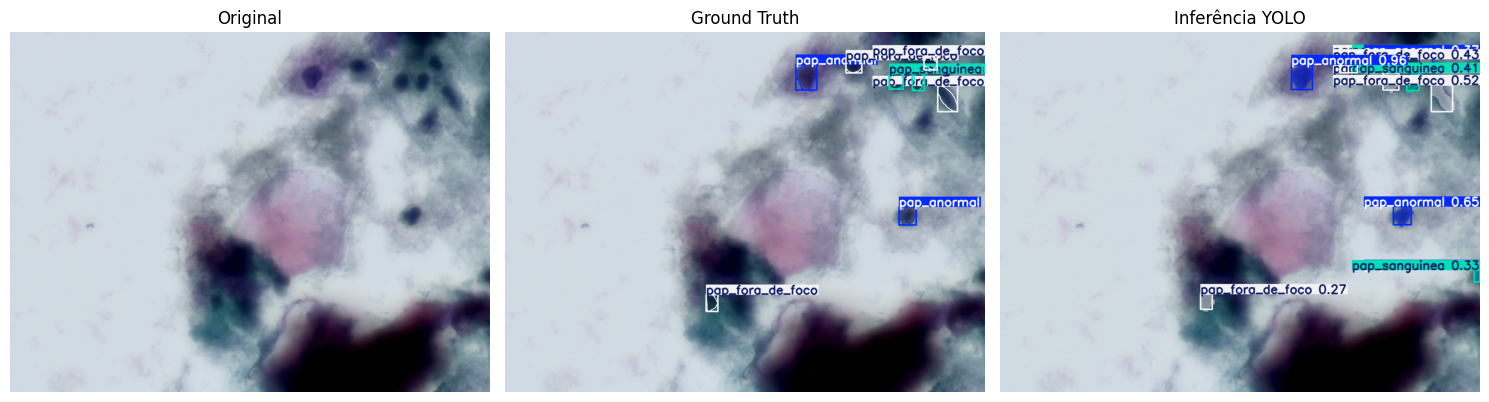

GT path: /home/jovyan/arquivos/Citologia/Datasets/Unificado/v1/yolo_format/test/labels/2019_07_10__14_48__0045_b0s0c0x100978-1600y47646-1200m6626.txt


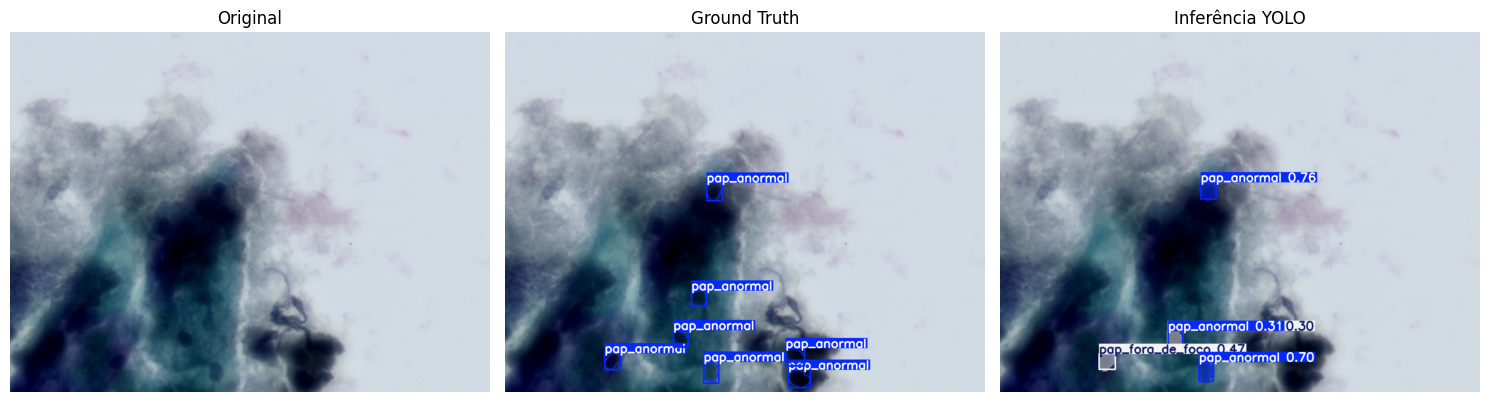

GT path: /home/jovyan/arquivos/Citologia/Datasets/Unificado/v1/yolo_format/test/labels/2019_07_10__14_48__0045_b0s0c0x102335-1600y127466-1200m17653.txt


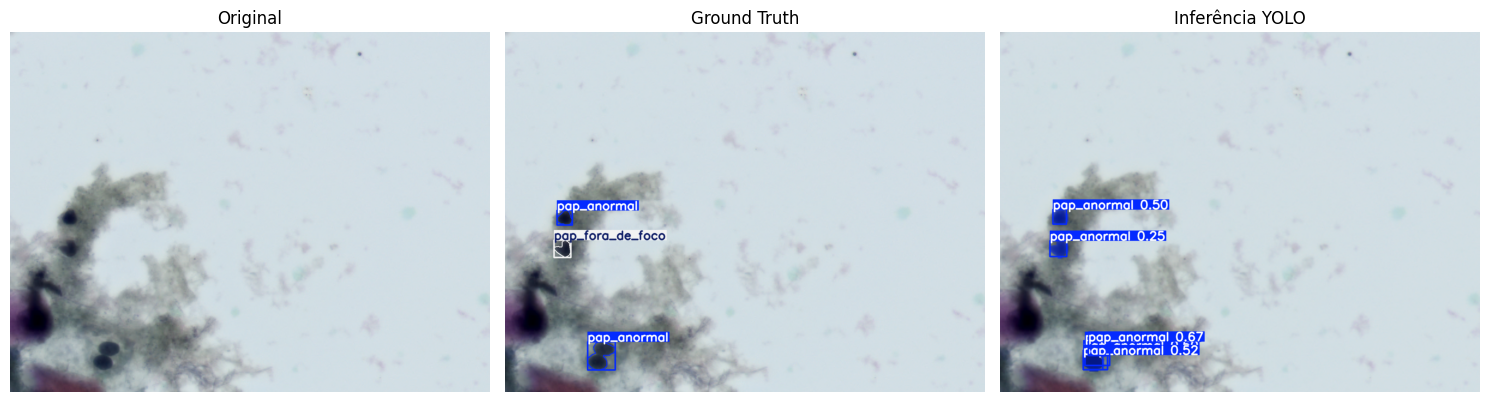

In [ ]:
from ultralytics.utils.plotting import Annotator, colors
import numpy as np
import yaml
import cv2
import os
import matplotlib.pyplot as plt

def load_names_from_yaml(yaml_path):
    with open(yaml_path, 'r') as f:
        yml = yaml.safe_load(f)
    names = yml.get('names', {})
    if isinstance(names, list):
        return {i: n for i, n in enumerate(names)}
    return {int(k): v for k, v in names.items()}

def plot_gt_vs_yolo_pred(image_paths, model, N=5, data_dir=None, mode="test", yaml_path=None):
    class_names = load_names_from_yaml(yaml_path) if yaml_path else {}
    results = model(image_paths[:N])

    for r in results:
        orig = r.orig_img.copy()
        gt = orig.copy()
        annotator = Annotator(gt, example=orig)

        base = os.path.splitext(os.path.basename(r.path))[0]
        label_file = os.path.join(data_dir, mode, "labels", base + ".txt")
        print(f"GT path: {label_file}")

        if os.path.exists(label_file):
            for line in open(label_file):
                vals = line.strip().split()
                cls = int(float(vals[0]))
                label = class_names.get(cls, str(cls))
                col = colors(cls, bgr=True)

                if len(vals) > 5:
                    pts = np.array(vals[5:], dtype=float).reshape(-1, 2)
                    pts[:, 0] *= gt.shape[1]
                    pts[:, 1] *= gt.shape[0]
                    pts = pts.astype(int)

                    cv2.polylines(gt, [pts], True, col, 2)

                    x, y, w, h = cv2.boundingRect(pts)
                    annotator.box_label([x, y, x+w, y+h], label, color=col)
                else:
                    _, cx, cy, w, h = map(float, vals[:5])
                    H, W = gt.shape[:2]
                    xmin = int((cx - w/2)*W)
                    xmax = int((cx + w/2)*W)
                    ymin = int((cy - h/2)*H)
                    ymax = int((cy + h/2)*H)
                    annotator.box_label([xmin, ymin, xmax, ymax], label, color=col)
        else:
            cv2.putText(gt, 'Sem GT', (50,50),
                        cv2.FONT_HERSHEY_SIMPLEX, 2, (255,255,255), 2)

        gt = annotator.result()
        pred = r.plot()

        plt.figure(figsize=(15,5))
        plt.subplot(1,3,1); plt.imshow(cv2.cvtColor(orig, cv2.COLOR_BGR2RGB)); plt.title('Original'); plt.axis('off')
        plt.subplot(1,3,2); plt.imshow(cv2.cvtColor(gt, cv2.COLOR_BGR2RGB)); plt.title('Ground Truth'); plt.axis('off')
        plt.subplot(1,3,3); plt.imshow(cv2.cvtColor(pred, cv2.COLOR_BGR2RGB)); plt.title('Inferência YOLO'); plt.axis('off')
        plt.tight_layout(); plt.show()



plot_gt_vs_yolo_pred(image_paths, model, N=5, data_dir=BASE_DATA, mode='test', yaml_path=DATA_YAML)


0: 608x800 5 pap_anormals, 1.5ms
1: 608x800 4 pap_anormals, 1 pap_sanguinea, 1.5ms
2: 608x800 4 pap_anormals, 5 pap_fora_de_focos, 3 pap_sanguineas, 1.5ms
3: 608x800 3 pap_anormals, 2 pap_fora_de_focos, 1.5ms
4: 608x800 6 pap_anormals, 1.5ms
Speed: 2.3ms preprocess, 1.5ms inference, 0.7ms postprocess per image at shape (1, 3, 608, 800)


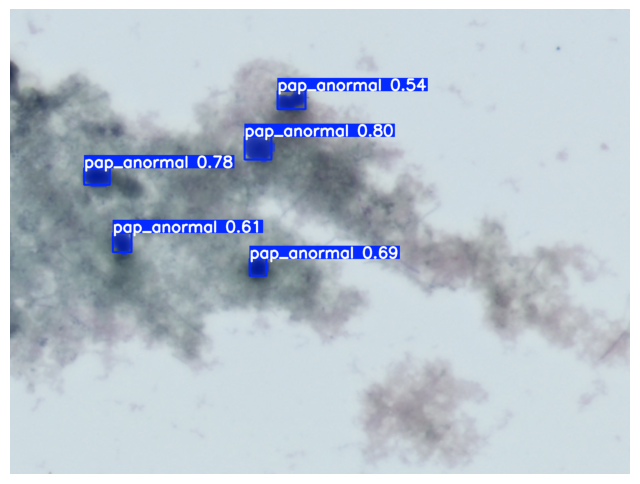

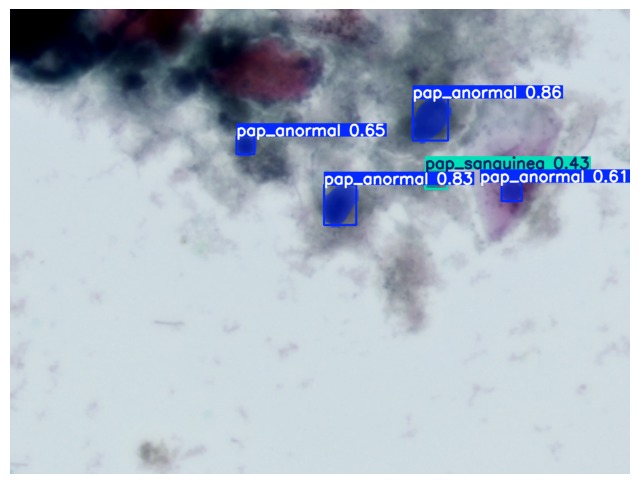

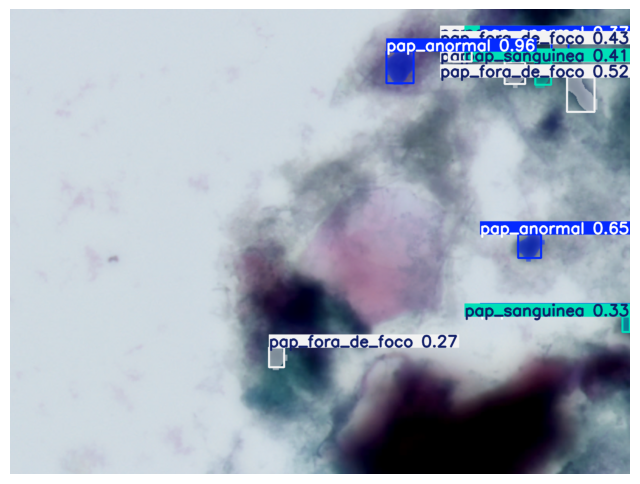

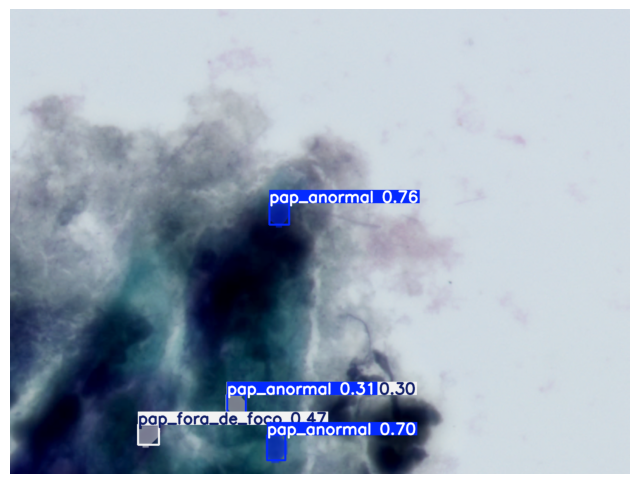

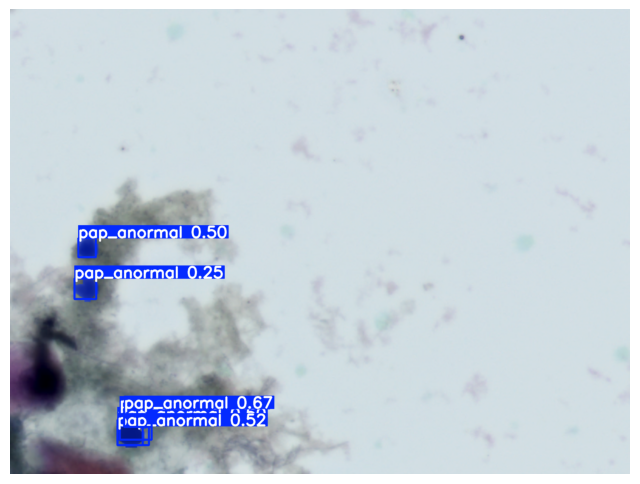

In [35]:
def plot_yolo_predictions(image_paths, model, N=5, title=True):
    results = model(image_paths[:N])
    for r in results:
        pred_img = r.plot()
        img_path = r.path

        plt.figure(figsize=(8, 8))
        plt.imshow(cv2.cvtColor(pred_img, cv2.COLOR_BGR2RGB))
        if title:
            plt.title(f'img: {os.path.basename(img_path)}')
        plt.axis('off')
        plt.show()


plot_yolo_predictions(image_paths, model, N=5, title=False)